# Imports

In [1]:
import time
import torch
from torch import nn, optim
from tqdm import tqdm
from dataset import WheatSegDatasetDETR, WheatSegDatasetDETRMultiAug
from Detr import DETR
import cv2
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import wandb
import os
from torch.utils.data import DataLoader, Subset
from segmentation_models_pytorch.losses import TverskyLoss
# Import TverskyLoss from torch

from utils import *
from definitions import *

# Select CUDA if available, otherwise CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
DETR_MODEL_SAVE_PATH = "detr.pth"
CSV_PATH = "/gpfs0/bgu-benshimo/users/guyperet/final_IP_project/data_detr/train.csv"
IMAGES_DIR_PATH = "/gpfs0/bgu-benshimo/users/guyperet/final_IP_project/data_detr/train"

Using device: cuda


# DataLoaders, Model, Loss & Optimizer

In [2]:
full_dataset = WheatSegDatasetDETRMultiAug(csv_path=CSV_PATH, images_dir=IMAGES_DIR_PATH)
# Split to Train and Validation using VAL_RATIO
val_indices = np.random.choice(
    len(full_dataset),
    size=int(len(full_dataset) * VAL_RATIO),
    replace=False
)
val_dataset = Subset(full_dataset, val_indices)
train_indices = list(set(range(len(full_dataset))) - set(val_indices))
train_dataset = Subset(full_dataset, train_indices)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=full_dataset.collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=full_dataset.collate_fn,
    pin_memory=True
)

print(f"number of training samples: {len(train_loader.dataset)}")
print(f"number of validation samples: {len(val_loader.dataset)}")
print(f"dataloaders created with batch size {BATCH_SIZE} and {NUM_WORKERS} workers")
print(f"=== Dataloaders Summary ===")
print(f"Train Loader: {len(train_loader)} batches")
print(f"Validation Loader: {len(val_loader)} batches")


model   = DETR(num_classes=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"=== Model Summary ===")
print(model)

/gpfs0/bgu-benshimo/users/guyperet/final_IP_project/src/dataset.py:40: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(256, 256, always_apply=True),      # <── NEW
/gpfs0/bgu-benshimo/users/guyperet/final_IP_project/src/dataset.py:69: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  return A.Compose([A.GaussNoise(var_limit=(10, 50), p=1.0), *_post()],
/gpfs0/bgu-benshimo/users/guyperet/final_IP_project/src/dataset.py:91: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=1.0),
/gpfs0/bgu-benshimo/users/guyperet/final_IP_project/src/dataset.py:108: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=1.0),


number of training samples: 27376
number of validation samples: 6844
dataloaders created with batch size 16 and 4 workers
=== Dataloaders Summary ===
Train Loader: 1711 batches
Validation Loader: 428 batches


Using cache found in /gpfs0/bgu-benshimo/users/guyperet/.cache/torch/hub/pytorch_vision_v0.10.0
/gpfs0/bgu-benshimo/users/guyperet/env/wheat-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfs0/bgu-benshimo/users/guyperet/env/wheat-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/gpfs0/bgu-benshimo/users/guyperet/env/wheat-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because enc

=== Model Summary ===
DETR(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

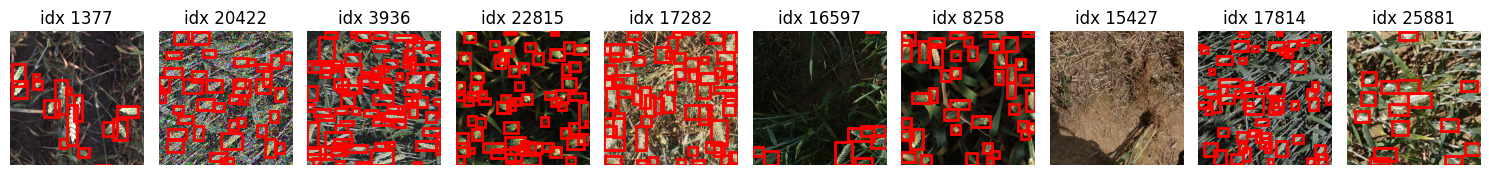

In [36]:
def plot_sample_images(dataset, num_samples=5):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    H = W = 256                                                  # resize size

    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        img_t, tgt = dataset[idx]

        img = img_t.permute(1, 2, 0).cpu().numpy()               # HWC, [0,1]

        for cx, cy, bw, bh in tgt["boxes"]:
            # back-convert to absolute xyxy in pixels
            cx *= W;  cy *= H
            bw *= W; bh *= H
            x1 = cx - bw / 2
            y1 = cy - bh / 2
            rect = Rectangle((x1, y1), bw, bh,
                             linewidth=2, edgecolor="r", facecolor="none")
            axs[i].add_patch(rect)

        axs[i].imshow(img)
        axs[i].set_title(f"idx {idx}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()
    
plot_sample_images(train_dataset, num_samples=10)

# Dataset Sanity Check

In [3]:
# Debug: Test dataset creation and access
print(f"Train dataset length: {len(train_dataset)}")
print(f"Val dataset length: {len(val_dataset)}")

# Try to access the first item
try:
    first_item = train_dataset[0]
    print(first_item[1].items())
    print("Dataset access successful!")
except Exception as e:
    print(f"Error accessing first item: {e}")
    
# Check if datasets have any items
if len(train_dataset) == 0:
    print("ERROR: Train dataset is empty!")
if len(val_dataset) == 0:
    print("ERROR: Validation dataset is empty!")

Train dataset length: 2738
Val dataset length: 684
dict_items([('boxes', tensor([[0.0181, 0.6929, 0.0361, 0.1084],
        [0.0659, 0.8457, 0.1318, 0.0957],
        [0.0107, 0.2271, 0.0215, 0.0791],
        [0.0347, 0.3525, 0.0615, 0.0371],
        [0.1201, 0.3657, 0.0801, 0.0791],
        [0.0527, 0.3130, 0.0469, 0.0479],
        [0.2061, 0.3350, 0.0684, 0.0527],
        [0.2056, 0.1479, 0.0674, 0.0498],
        [0.2188, 0.0786, 0.0410, 0.0830],
        [0.0464, 0.1670, 0.0869, 0.0566],
        [0.2598, 0.0122, 0.0586, 0.0244],
        [0.3579, 0.0278, 0.0732, 0.0557],
        [0.8110, 0.0469, 0.0674, 0.0938],
        [0.6724, 0.0674, 0.0576, 0.0879],
        [0.5957, 0.1182, 0.1367, 0.0781],
        [0.2710, 0.1733, 0.0869, 0.0498],
        [0.4404, 0.1797, 0.0566, 0.0488],
        [0.5513, 0.1807, 0.2002, 0.0625],
        [0.5098, 0.2310, 0.1055, 0.0518],
        [0.4736, 0.2725, 0.1328, 0.0859],
        [0.3076, 0.2759, 0.0547, 0.0498],
        [0.3335, 0.3516, 0.1143, 0.0742],
   

# Training Loop

In [4]:
ckpt_cb = ModelCheckpoint(  dirpath="checkpoints",
                            filename="detr-{epoch:02d}-{val_map:.3f}",
                            monitor="val_map",
                            mode="max",
                            save_top_k=3,
                            every_n_epochs=1,)
wandb_logger = WandbLogger(project="wheat-detection", log_model="all")
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator="auto",
    callbacks=[ckpt_cb],
    logger=wandb_logger,
    enable_checkpointing= True,
    enable_progress_bar=True,
    enable_model_summary=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: guyperet (guyperet-ben-gurion-university-of-the-negev) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/gpfs0/bgu-benshimo/users/guyperet/env/wheat-env/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /gpfs0/bgu-benshimo/users/guyperet/final_IP_project/src/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                    | Params | Mode 
----------------------------------------------------------------------
0 | backbone          | Sequential              | 23.5 M | train
1 | input_proj        | Conv2d                  | 524 K  | train
2 | position_encoding | PositionEmbeddingSine   | 0      | train
3 | transformer       | Transformer             | 17.4 M | train
4 | query_embed       | Embedding               | 25.6 K | train
5 | class_embed       | Linear                  | 514    | train
6 | bbox_embed        | MLP                     | 132 K  | train
7 | map_metric        | MeanAveragePrecision    | 0      | train
8 | criterion         | HungarianSetCriterion1C | 0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/gpfs0/bgu-benshimo/users/guyperet/env/wheat-env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.63it/s]

/gpfs0/bgu-benshimo/users/guyperet/env/wheat-env/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


/gpfs0/bgu-benshimo/users/guyperet/env/wheat-env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 685/685 [12:22<00:00,  0.92it/s, v_num=ajd7, train_loss_step=3.980]

/gpfs0/bgu-benshimo/users/guyperet/env/wheat-env/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1:  22%|██▏       | 150/685 [02:27<08:46,  1.02it/s, v_num=ajd7, train_loss_step=8.510, val_loss=14.20, val_map=1.79e-6, train_loss_epoch=7.530]


Detected KeyboardInterrupt, attempting graceful shutdown ...
